# Apr 12th, 2022 (ent fixed + some supp)

**Motivation**: Entropy now without cumulative part.  Plot OCs for different num K and different thresholds.  Compare entropy distributions for different num K and density values. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(_fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

_BOLD = 'BOLD'
_CA = r'Ca$^{2\!\!+}$'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_CA: mako(0.6), _BOLD: rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

## Entropy with log(k) / log(5)

### Anim h?

In [5]:
num = 20
bins = np.linspace(-1 / num, 1.0, num + 2)
xs = (bins[1:] + bins[:-1]) / 2
xs[0] = 0

In [6]:
sns.histplot(gr_bold.anim_h.ravel(), bins=bins, color=pal['bold-lite'])
sns.histplot(gr_ca.anim_h.ravel(), bins=bins, color=pal['ca2']);

KeyError: 'bold-lite'

In [7]:
%%time

i, j, k = gr_bold.run_h.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

h_bold = cut_data(
    data=np.expand_dims(gr_bold.anim_h, 1),
    bins=bins,
    oc_only=True,
)[0].squeeze()
h_bold_avg = bn.nanmean(h_bold, 0)

boot = bootstrap(
    x=gr_bold.run_pi_prune,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = cut_data(
    data=boot,
    bins=bins,
    oc_only=True,
)[0].squeeze()
boot = bn.nanmean(boot, 1)
se_bold = bn.nanstd(boot, 0, ddof=1)


h_ca = cut_data(
    data=np.expand_dims(gr_ca.anim_h, 1),
    bins=bins,
    oc_only=True,
)[0].squeeze()
h_ca_avg = bn.nanmean(h_ca, 0)

boot = bootstrap(
    x=gr_ca.run_pi_prune,
    n_resamples=int(1e4),
    batch=5,
    dims=dims,
    est=None,
)
boot = bn.nanmean(bn.nanmean(boot, 3), 2)
boot = sp_stats.entropy(boot, axis=-2) / np.log(5)
boot = cut_data(
    data=boot,
    bins=bins,
    oc_only=True,
)[0].squeeze()
boot = bn.nanmean(boot, 1)
se_ca = bn.nanstd(boot, 0, ddof=1)

CPU times: user 20.9 s, sys: 18.2 s, total: 39 s
Wall time: 39 s


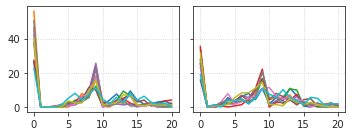

In [8]:
fig, axes = create_figure(1, 2, (5, 2), 'all', 'all')
axes[0].plot(h_bold.T)
axes[1].plot(h_ca.T)
add_grid(axes)
plt.show()

In [9]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
t = sp_stats.t.ppf(whis, dof)
t

2.2621571627409915

In [10]:
save_dir = pjoin(fig_dir, 'entropy')
os.makedirs(save_dir, exist_ok=True)

In [11]:
from matplotlib.pyplot import text as mp_txt
set_style()

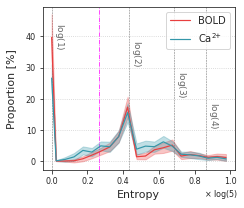

In [14]:
fig, ax = create_figure(1, 1, figsize=(3.5, 3), sharex='col')

data2p = {_BOLD: (h_bold_avg, se_bold), _CA: (h_ca_avg, se_ca)}
for lbl, (y, se) in data2p.items():
    lo = y - se * t
    hi = y + se * t
    ax.plot(xs, y, color=pal[lbl], lw=1.2, label=lbl, alpha=1.0)
    # ax.plot(xs, lo, color=color, lw=0.1, alpha=0.1)
    # ax.plot(xs, hi, color=color, lw=0.1, alpha=0.1)
    ax.fill_between(xs, lo, hi, color=pal[lbl], alpha=0.3)
ax.set_ylabel('Proportion [%]', fontsize=11, labelpad=8.5)
# ax.tick_params(axis='y', labelsize=8)
# ax.set_yscale('log')
ax.grid(axis='y')
ax.legend(loc='upper right', fontsize=10)

y_loc = [44.5, 39, 29, 19]
for i, y in enumerate(y_loc, start=1):
    x = np.log(i) / np.log(5)
    ax.axvline(x, color='dimgrey', ls='--', lw=0.5, zorder=0)
    mp_txt(
        x=x + 0.01,
        y=y,
        s=f"$\log({i})$",
        fontsize=9,
        rotation=270,
        color='dimgrey',
        va='top',
    )
x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
ax.axvline(x, color='magenta', ls='-.', lw=0.7, zorder=0)
ax.set_xlabel('Entropy', fontsize=11)

ax.tick_params(axis='both', labelsize=8)
mp_txt(
    x=0.85,
    y=-11.5,
    s=r"$\times \,\, \log(5)$",
    fontsize=8,
)

name = 'entanim'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
plt.show()

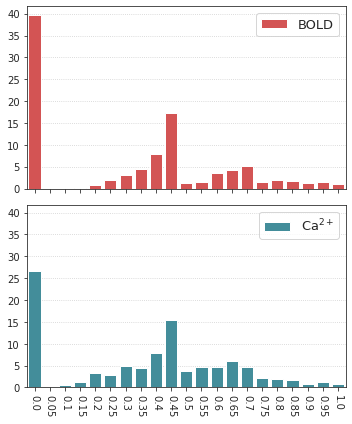

In [20]:
fig, axes = create_figure(2, 1, (5, 6), 'all', 'all')
sns.barplot(x=np.round(xs, 3), y=h_bold.mean(0), color=pal['bold-lite'], label='BOLD', ax=axes[0])
sns.barplot(x=np.round(xs, 3), y=h_ca.mean(0), color=pal['ca2'], label=r'Ca$^{2+}$', ax=axes[1])
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)
    ax.grid(axis='y')
    ax.legend(loc='upper right', fontsize=13)
axes[1].set_xticklabels(np.round(bins[1:], 3));

In [21]:
h_bold = sp_stats.entropy(gr_bold.grp_pi_prune) / np.log(gr_bold.num_k)
h_ca = sp_stats.entropy(gr_ca.grp_pi_prune) / np.log(gr_ca.num_k)

hr_bold = sp_stats.rankdata(h_bold)
hr_ca = sp_stats.rankdata(h_ca)


h_thres = -np.inf
hpb = gr_bold.project_vec(h_bold, thres=h_thres, add_disjoint=False)
hpc = gr_ca.project_vec(h_ca, thres=h_thres, add_disjoint=False)

hrpb = gr_bold.project_vec(hr_bold, thres=h_thres, add_disjoint=False)
hrpc = gr_ca.project_vec(hr_ca, thres=h_thres, add_disjoint=False)


trb = gr_bold.trim2d(hrpb)
trc = gr_bold.trim2d(hrpc)

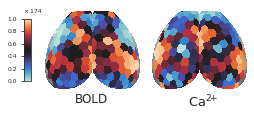

In [45]:
fig = plt.figure(figsize=(4., 3), constrained_layout=True)
gs = GridSpec(3, 3, height_ratios=[2, 3, 2], width_ratios=[0.08, 1, 1])

ax = fig.add_subplot(gs[:, 1])
x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = trb['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
ax.imshow(x2p, cmap='icefire', interpolation='none')#'antialiased')
ax.set_xlabel('BOLD', fontsize=12)
remove_ticks(ax)

ax = fig.add_subplot(gs[:, 2])
x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = trc['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
im = ax.imshow(x2p, cmap='icefire', interpolation='none')#'antialiased')
ax.set_xlabel(r'Ca$^{2\!\!+}$', fontsize=13, x=0.54)
remove_ticks(ax)

cax = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(im, cax=cax)
ticks = [0.2, 0.4, 0.6, 0.8]
cbar.set_ticks([1] + [e * len(gr_ca.n2l) for e in ticks] + [173.0])
cax.set_yticklabels([0.0] + ticks + [1.0])
cax.tick_params(labelsize=6)
cax.yaxis.tick_left()

mp_txt(
    x=-20,
    y=190,
    s=r"$\times \,\, 174$",
    fontsize=6,
)

name = 'ent-ctx-horiz'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

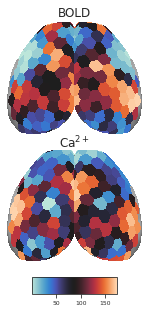

In [16]:
fig = plt.figure(figsize=(4, 5), constrained_layout=True)
gs = GridSpec(3, 3, width_ratios=[1, 1.5, 1.0], height_ratios=[1, 1, 0.15])

ax = fig.add_subplot(gs[0, :])
x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trb['proj-top'][0], sigma=1)
x2p = trb['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
ax.imshow(x2p, cmap='icefire', interpolation='none')
ax.set_title('BOLD', fontsize=12, y=0.99)
remove_ticks(ax)

ax = fig.add_subplot(gs[1, :])
x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
ax.imshow(x2p, cmap='Greys_r')

# x2p = gaussian_filter(trc['proj-top'][0], sigma=1)
x2p = trc['proj-top'][0].copy()
x2p = np.ma.masked_where(x2p == 0, x2p)
im = ax.imshow(x2p, cmap='icefire', interpolation='none')
ax.set_title(r'Ca$^{2+}$', fontsize=12, y=0.96)
remove_ticks(ax)

cax = fig.add_subplot(gs[2, 1])
plt.colorbar(im, cax=cax, orientation='horizontal')
cax.tick_params(labelsize=6) 

name = 'ent-ctx-4by5'
figname = f"{name}.pdf"
# fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

### d, K, variation

In [17]:
%%time

rho = collections.defaultdict(dict)
cos = collections.defaultdict(dict)
hbb = collections.defaultdict(dict)
hcc = collections.defaultdict(dict)
ocb = collections.defaultdict(dict)
occ = collections.defaultdict(dict)
for d in [10, 20]:
    _props_b = props_bold.copy()
    _props_c = props_ca.copy()
    _props_b['perc'] = f"p{d}-sample"
    _props_c['perc'] = f"p{d}-sample"
    for i, k in enumerate(range(3, 10)):
        _props_b['num_k'] = k
        _props_c['num_k'] = k
        try:
            _gr_c = Group(**_props_c).fit_group()
            _gr_b = Group(**_props_b).fit_group()
        except ValueError:
            continue
            
        good_nodes = np.logical_and(
            np.isnan(_gr_b.grp_pi_prune).sum(0) == 0,
            np.isnan(_gr_c.grp_pi_prune).sum(0) == 0,
        )
            
        # COS sim
        sim = dist2sim(sp_dist.cdist(
            XA=_gr_b.grp_pi[:, good_nodes],
            XB=_gr_c.grp_pi[:, good_nodes],
            metric='cosine',
        ))
        mapping = find_best_match(sim)
        ids = list(mapping.values())
        
        _gr_b.pi = _gr_b.grp_pi
        _gr_c.pi = _gr_c.grp_pi[ids]
        
        sim = dist2sim(sp_dist.cdist(
            XA=_gr_b.grp_pi_prune[:, good_nodes],
            XB=_gr_c.grp_pi_prune[:, good_nodes][ids],
            metric='cosine',
        ))
        cos[d][k] = sim # .diagonal().mean()
        # cos_sim[(d, k)] = sim
        # sim = sim.diagonal()
        # scores = {i + 1: s for i, s in enumerate(sim)}
        # scores = {**scores, 100: sim.mean()}

        # Entropy
        h_bold = sp_stats.entropy(_gr_b.grp_pi_prune) / np.log(_gr_b.num_k)
        h_ca = sp_stats.entropy(_gr_c.grp_pi_prune) / np.log(_gr_c.num_k)
        hr_bold = sp_stats.rankdata(h_bold)
        hr_ca = sp_stats.rankdata(h_ca)

        h_thres = -np.inf
        hpb = _gr_b.project_vec(h_bold, thres=h_thres, add_disjoint=False)
        hpc = _gr_c.project_vec(h_ca, thres=h_thres, add_disjoint=False)
        hrpb = _gr_b.project_vec(hr_bold, thres=h_thres, add_disjoint=False)
        hrpc = _gr_c.project_vec(hr_ca, thres=h_thres, add_disjoint=False)
        trb = _gr_b.trim2d(hrpb)
        trc = _gr_b.trim2d(hrpc)
        
        rho[d][k] = sp_stats.pearsonr(hr_bold, hr_ca)[0]
        hbb[d][k] = trb['proj-top'][0]
        hcc[d][k] = trc['proj-top'][0]

        # OCs
        proj_b = _gr_b.project_vec()
        proj_c = _gr_c.project_vec()
        trb = _gr_b.trim2d(proj_b)
        trc = _gr_c.trim2d(proj_c)

        ocb[d][k] = trb['proj-top']
        occ[d][k] = trc['proj-top']

CPU times: user 16.6 s, sys: 4.49 s, total: 21.1 s
Wall time: 21.1 s


In [18]:
fig_dir = pjoin(_fig_dir, 'supp')
os.makedirs(fig_dir, exist_ok=True)

In [19]:
save_dir = fig_dir

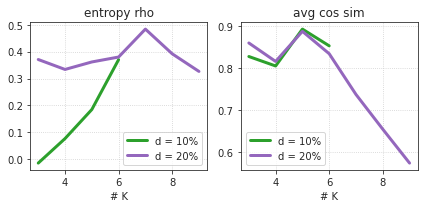

In [20]:
fig, axes = create_figure(1, 2, (6, 3), 'all')
ax = axes[0]
for d, data in rho.items():
    ax.plot(data.keys(), data.values(), label=f'd = {d}%', color=f'C{d%8}', lw=3)
ax.set_title('entropy rho')
ax = axes[1]
for d, data in cos.items():
    x = {k: s.diagonal().mean() for k, s in data.items()}
    ax.plot(x.keys(), x.values(), label=f'd = {d}%', color=f'C{d%8}', lw=3)
ax.set_title('avg cos sim')
for ax in axes.flat:
    ax.legend()
    ax.grid()
    ax.set_xlabel('# K')
name = 'CosRho'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

In [21]:
save_dir = pjoin(fig_dir, 's-entropy')
os.makedirs(save_dir, exist_ok=True)

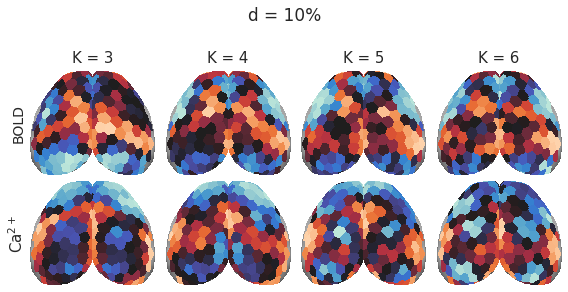

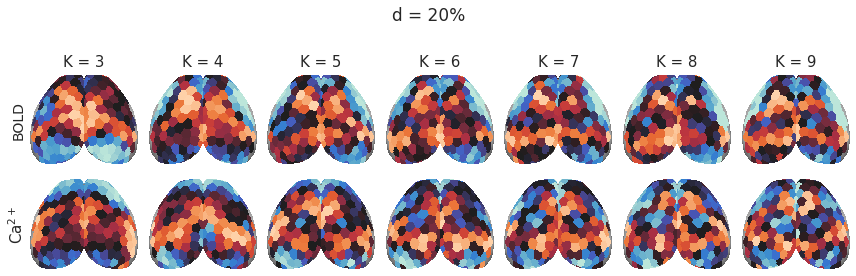

In [22]:
for d in hbb:
    fig, axes = create_figure(2, len(hbb[d]), (4 * (1 + d // 10), 4))

    for i, k in enumerate(range(3, 10)):
        xb = hbb[d].get(k)
        xc = hcc[d].get(k)
        if xb is None or xc is None:
            continue
        ax = axes[0, i]
        ax.imshow(mwh(trb['top'] == 0, trb['top']), cmap='Greys_r')
        ax.imshow(mwh(xb == 0, xb), cmap='icefire')
        ax.set_title(f"K = {k}", fontsize=15, y=1.03)
        if i == 0:
            ax.set_ylabel('BOLD', fontsize=14)

        ax = axes[1, i]
        ax.imshow(mwh(trc['top'] == 0, trc['top']), cmap='Greys_r')
        ax.imshow(mwh(xc == 0, xc), cmap='icefire')
        if i == 0:
            ax.set_ylabel(r'Ca$^{2+}$', fontsize=15)
    fig.suptitle(f"d = {d}%", fontsize=17, y=1.02)
    remove_ticks(axes)
    
    name = f'd{d}'
    figname = f"{name}.pdf"
    fig.savefig(pjoin(save_dir, figname), **fig_kws)
    for dpi in [600, 1000]:
        figname = f"{name}_dpi{int(dpi / 100)}.png"
        # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
    
    plt.show()

In [23]:
for k, x in ocb[10].items():
    print(k, np.round(np.max(x[:-1]), 2), np.round(np.max(occ[10][k][:-1]), 2))

3 0.74 0.94

4 0.77 0.85

5 0.74 0.74

6 0.75 0.7

In [24]:
for k, x in ocb[20].items():
    print(k, np.round(np.max(x[:-1]), 2), np.round(np.max(occ[20][k][:-1]), 2))

3 0.74 0.93

4 0.77 0.85

5 0.79 0.77

6 0.78 0.75

7 0.73 0.68

8 0.71 0.69

9 0.67 0.61

In [25]:
min_thres = 0.15
vmin = 0.15
vmax = 0.8
cm = 'magma'

In [26]:
x = np.array([3, 5, 9])
y = np.array([7, 10, 16])
a, b, c = np.polyfit(x, y, 2)
a, b, c

(6.201227114042485e-16, 1.4999999999999938, 2.500000000000013)

In [27]:
a * x ** 2 + b * x + c

array([ 7., 10., 16.])

In [28]:
save_dir = pjoin(fig_dir, 's-OCs')
os.makedirs(save_dir, exist_ok=True)

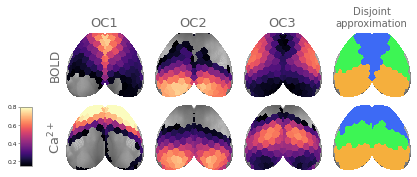

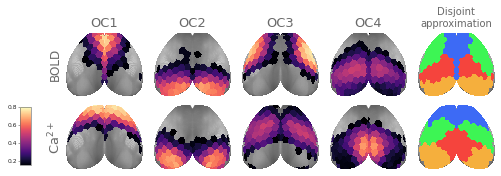

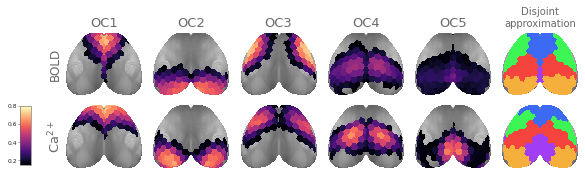

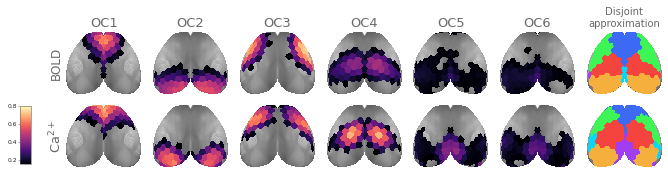

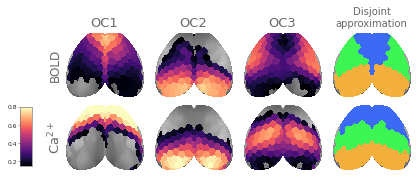

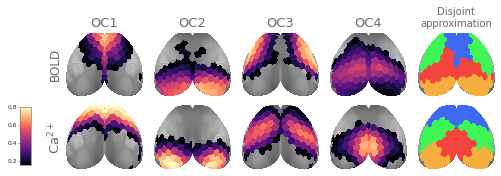

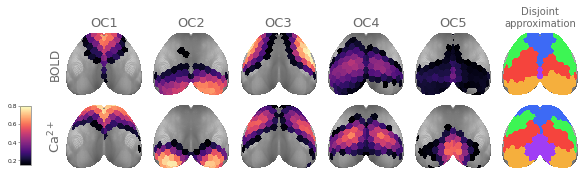

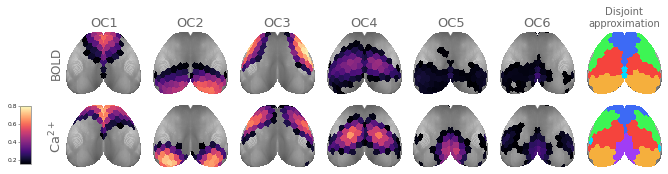

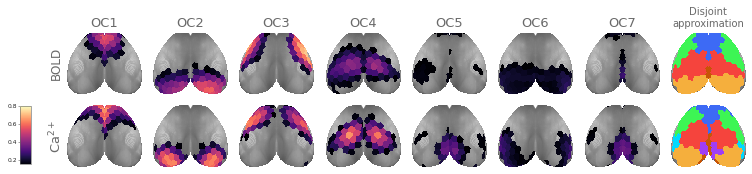

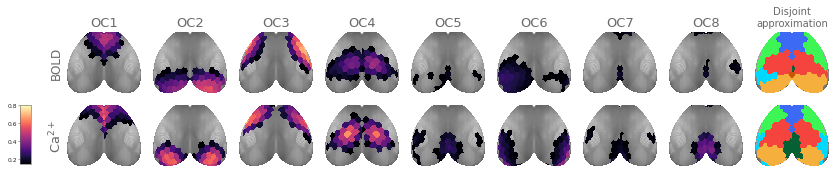

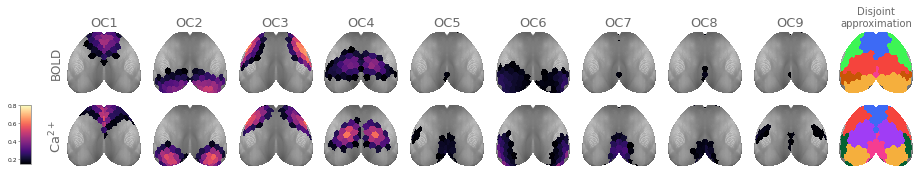

In [29]:
for d in [10, 20]:
    for k in ocb[d]:
        fig_x = a * k ** 2 + b * k + c
        fig = plt.figure(figsize=(fig_x, 2.6), tight_layout=False, constrained_layout=False)
        gs = GridSpec(6, k + 3, height_ratios=[0., 3, 0.1] * 2, width_ratios=[0.15, 0.15] + [1] * (k + 1))

        for i in range(2, k + 3):
            ax = fig.add_subplot(gs[:3, i])
            x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
            ax.imshow(x2p, cmap='Greys_r')

            x2p = ocb[d][k][i - 2]
            if i == k + 2:
                x2p = np.ma.masked_where(x2p == 0, x2p)
                ax.imshow(x2p, cmap=get_cluster_cmap(range(k)))
                ax.set_title(f'Disjoint\napproximation', fontsize=10, color='dimgrey')
            else:
                x2p = np.ma.masked_where(x2p < min_thres, x2p)
                ax.imshow(x2p, cmap=cm, vmin=vmin, vmax=vmax)
                ax.set_title(f'OC{i - 1}', fontsize=13, color='dimgrey')
            if i == 2:
                ax.set_ylabel(r'BOLD', fontsize=12, color='dimgrey')
            remove_ticks(ax)

            ax = fig.add_subplot(gs[3:, i])
            x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
            ax.imshow(x2p, cmap='Greys_r')

            x2p = occ[d][k][i - 2]
            if i == k + 2:
                x2p = np.ma.masked_where(x2p == 0, x2p)
                ax.imshow(x2p, cmap=get_cluster_cmap(range(k)))
            else:
                x2p = np.ma.masked_where(x2p < min_thres, x2p)
                im = ax.imshow(x2p, cmap=cm, vmin=vmin, vmax=vmax, interpolation='none')
            if i == 2:
                ax.set_ylabel(r'Ca$^{2+}$', fontsize=13, labelpad=2.5, color='dimgrey')
            remove_ticks(ax)

        cax = fig.add_subplot(gs[4, 0])
        cbar = plt.colorbar(im, cax=cax)
        cax.yaxis.set_ticks_position('left')
        cax.tick_params(axis='y', labelsize=6, width=0.6, length=2, pad=1, color='dimgrey')
        cbar.outline.set_edgecolor('dimgrey')
        cbar.outline.set_linewidth(0.6)

        name = f'd{d}-k{k}'
        for ext in ['pdf']:
            figname = f"{name}.{ext}"
            fig.savefig(pjoin(save_dir, figname), **fig_kws)
        for dpi in [1000]:
            figname = f"{name}_dpi{int(dpi / 100)}.png"
            fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
        plt.show()

In [30]:
min_thres = 0.05

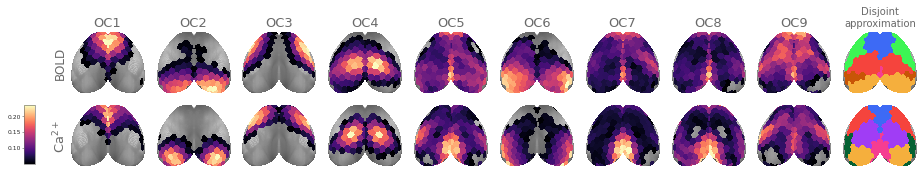

In [31]:
d = 20
k = 9

fig_x = a * k ** 2 + b * k + c
fig = plt.figure(figsize=(fig_x, 2.6), tight_layout=False, constrained_layout=False)
gs = GridSpec(6, k + 3, height_ratios=[0., 3, 0.1] * 2, width_ratios=[0.15, 0.15] + [1] * (k + 1))

for i in range(2, k + 3):
    ax = fig.add_subplot(gs[:3, i])
    x2p = np.ma.masked_where(trb['top'] == 0, trb['top'])
    ax.imshow(x2p, cmap='Greys_r')

    x2p = ocb[d][k][i - 2]
    if i == k + 2:
        x2p = np.ma.masked_where(x2p == 0, x2p)
        ax.imshow(x2p, cmap=get_cluster_cmap(range(k)))
        ax.set_title(f'Disjoint\napproximation', fontsize=10, color='dimgrey')
    else:
        x2p = np.ma.masked_where(x2p < min_thres, x2p)
        ax.imshow(x2p, cmap=cm)
        ax.set_title(f'OC{i - 1}', fontsize=13, color='dimgrey')
    if i == 2:
        ax.set_ylabel(r'BOLD', fontsize=12, color='dimgrey')
    remove_ticks(ax)

    ax = fig.add_subplot(gs[3:, i])
    x2p = np.ma.masked_where(trc['top'] == 0, trc['top'])
    ax.imshow(x2p, cmap='Greys_r')

    x2p = occ[d][k][i - 2]
    if i == k + 2:
        x2p = np.ma.masked_where(x2p == 0, x2p)
        ax.imshow(x2p, cmap=get_cluster_cmap(range(k)))
    else:
        x2p = np.ma.masked_where(x2p < min_thres, x2p)
        im = ax.imshow(x2p, cmap=cm, interpolation='none')
    if i == 2:
        ax.set_ylabel(r'Ca$^{2+}$', fontsize=13, labelpad=2.5, color='dimgrey')
    remove_ticks(ax)

cax = fig.add_subplot(gs[4, 0])
cbar = plt.colorbar(im, cax=cax)
cax.yaxis.set_ticks_position('left')
cax.tick_params(axis='y', labelsize=6, width=0.6, length=2, pad=1, color='dimgrey')
cbar.outline.set_edgecolor('dimgrey')
cbar.outline.set_linewidth(0.6)
plt.show()

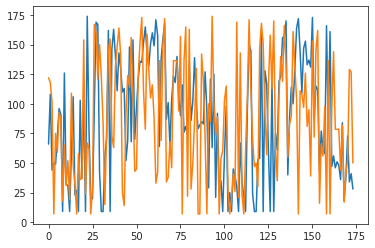

In [32]:
plt.plot(hr_bold)
plt.plot(hr_ca);

In [33]:
sp_stats.pearsonr(hr_bold, hr_ca)

(0.3263842750862723, 1.1064846661723603e-05)

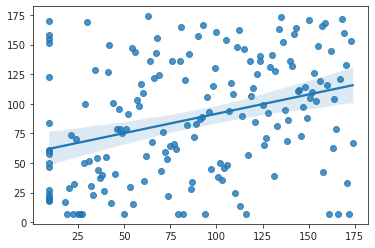

In [34]:
sns.regplot(x=hr_bold, y=hr_ca);

In [35]:
%%time

dims = {'sub': 10, 'ses': 3, 'run': 4}

h_b = collections.defaultdict(dict)
h_c = collections.defaultdict(dict)
se_b = collections.defaultdict(dict)
se_c = collections.defaultdict(dict)

for d in [10, 20]:
    _props_b = props_bold.copy()
    _props_c = props_ca.copy()
    _props_b['perc'] = f"p{d}-sample"
    _props_c['perc'] = f"p{d}-sample"
    for i, k in enumerate(range(3, 10)):
        _props_b['num_k'] = k
        _props_c['num_k'] = k
        try:
            _gr_c = Group(**_props_c).fit_group()
            _gr_b = Group(**_props_b).fit_group()
        except ValueError:
            continue

        # Entropy
        h_bold = sp_stats.entropy(_gr_b.grp_pi_prune) / np.log(_gr_b.num_k)
        h_ca = sp_stats.entropy(_gr_c.grp_pi_prune) / np.log(_gr_c.num_k)
        hr_bold = sp_stats.rankdata(h_bold)
        hr_ca = sp_stats.rankdata(h_ca)

        h_bold = cut_data(
            data=np.expand_dims(_gr_b.anim_h, 1),
            bins=bins,
            oc_only=True,
        )[0].squeeze()
        h_bold_avg = bn.nanmean(h_bold, 0)

        boot = bootstrap(
            x=_gr_b.run_pi_prune,
            n_resamples=int(1e4),
            batch=5,
            dims=dims,
            est=None,
        )
        boot = bn.nanmean(bn.nanmean(boot, 3), 2)
        boot = sp_stats.entropy(boot, axis=-2) / np.log(k)
        boot = cut_data(
            data=boot,
            bins=bins,
            oc_only=True,
        )[0].squeeze()
        boot = bn.nanmean(boot, 1)
        se_bold = bn.nanstd(boot, 0, ddof=1)

        h_ca = cut_data(
            data=np.expand_dims(_gr_c.anim_h, 1),
            bins=bins,
            oc_only=True,
        )[0].squeeze()
        h_ca_avg = bn.nanmean(h_ca, 0)

        boot = bootstrap(
            x=_gr_c.run_pi_prune,
            n_resamples=int(1e4),
            batch=5,
            dims=dims,
            est=None,
        )
        boot = bn.nanmean(bn.nanmean(boot, 3), 2)
        boot = sp_stats.entropy(boot, axis=-2) / np.log(k)
        boot = cut_data(
            data=boot,
            bins=bins,
            oc_only=True,
        )[0].squeeze()
        boot = bn.nanmean(boot, 1)
        se_ca = bn.nanstd(boot, 0, ddof=1)
        
        h_b[d][k] = h_bold_avg
        h_c[d][k] = h_ca_avg
        se_b[d][k] = se_bold
        se_c[d][k] = se_ca

CPU times: user 3min 50s, sys: 2min 34s, total: 6min 24s
Wall time: 6min 23s


In [36]:
save_dir = pjoin(fig_dir, 's-entropy')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/supp/s-entropy'

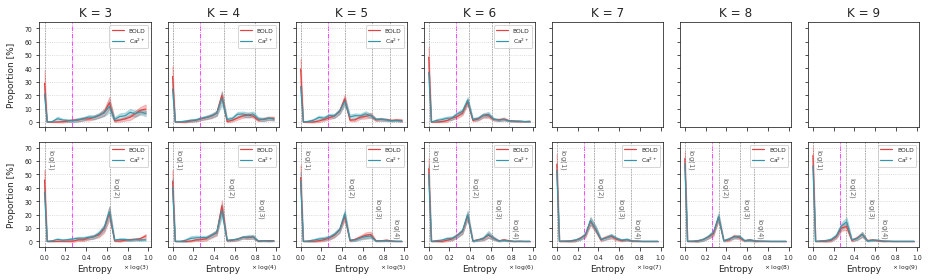

In [37]:
fig, axes = create_figure(2, 7, figsize=(13, 4), sharex='all', sharey='all')

for iii, d in enumerate([10, 20]):
    for jjj, k in enumerate(range(3, 10)):
        ax = axes[iii, jjj]
        if iii == 0:
            ax.set_title(f"K = {k}")
        
        try:
            data2p = {
                'BOLD': (h_b[d][k], se_b[d][k]),
                r'Ca$^{2+}$': (h_c[d][k], se_c[d][k]),
            }
        except KeyError:
            # ax.remove()
            continue
        
        for (lbl, (y, se)), color in zip(data2p.items(), [pal['bold-lite'], pal['ca2']]):
            lo = y - se * t
            hi = y + se * t
            ax.plot(xs, y, color=color, lw=1.2, label=lbl, alpha=1.0)
            # ax.plot(xs, lo, color=color, lw=0.1, alpha=0.1)
            # ax.plot(xs, hi, color=color, lw=0.1, alpha=0.1)
            ax.fill_between(xs, lo, hi, color=color, alpha=0.3)
        if jjj == 0:
            ax.set_ylabel('Proportion [%]', fontsize=9, labelpad=8.5)
        # ax.tick_params(axis='y', labelsize=8)
        # ax.set_yscale('log')
        ax.grid(axis='y')
        ax.legend(loc='upper right', fontsize=6)

        y_loc = [70, 49, 33, 18]
        for i, y in enumerate(y_loc, start=1):
            if i >= k:
                break
            x = np.log(i) / np.log(k)
            ax.axvline(x, color='dimgrey', ls='--', lw=0.5, zorder=0)
            if iii == 1:
                ax.text(
                    x=x + 0.01,
                    y=y,
                    s=f"$\log({i})$",
                    fontsize=7,
                    rotation=270,
                    color='dimgrey',
                    va='top',
                )
        x = (0.15 * np.log(1 / 0.15) + 0.85 * np.log(1 / 0.85)) / np.log(5)
        ax.axvline(x, color='magenta', ls='-.', lw=0.7, zorder=0)
        
        if iii == 1:
            ax.set_xlabel('Entropy', fontsize=9)
        
        ax.tick_params(axis='both', labelsize=6.1)
        if iii == 1:
            ax.text(
                x=0.76,
                y=-20,
                s=r"$\times \,\, \log($" + str(k) + r"$)$",
                fontsize=6,
            )

name = 's-entanim'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    # fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

plt.show()